In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
USE_GPU = torch.cuda.is_available()
BATCH_SIZE = 256

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [28]:
x = np.array([(i,j) for i in range(-4, 5, 2) for j in range(-4, 5, 2)] * 10000)
x = x + 0.1 * np.random.randn(*x.shape)
print(x.shape)

(250000, 2)


# spiral data

In [29]:
theta = np.linspace(0, 8*np.pi, 250000)  # 각도 범위를 정의합니다.
radius = np.linspace(0, 6, 250000)  # 반지름 범위를 정의합니다.
xx = radius * np.cos(theta) + 0.05 * np.random.randn(250000)  # x 좌표 계산
yy = radius * np.sin(theta) + 0.05 * np.random.randn(250000)  # y 좌표 계산

x = np.column_stack((xx, yy))  # x와 y 좌표를 합쳐서 데이터 생성

In [30]:
x.shape

(250000, 2)

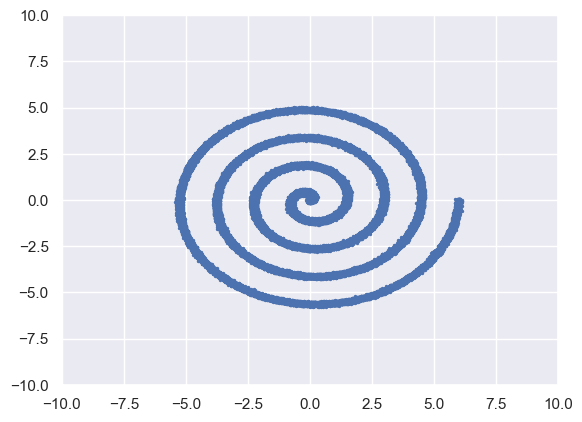

In [31]:
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.show()

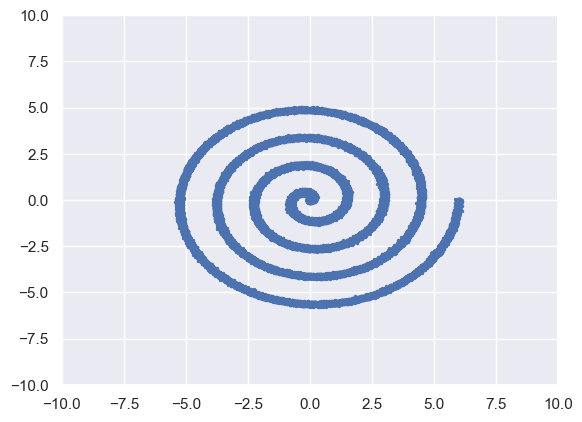

In [32]:
np.random.shuffle(x)
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.show()

In [19]:
class Generator(nn.Module):
    
    def __init__(self, input_size=10, output_size=2, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
                
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=2e-1)
        x = F.leaky_relu(self.fc2(x), negative_slope=2e-1)
        x = F.leaky_relu(self.fc3(x), negative_slope=2e-1)
        return x
        
class Discriminator(nn.Module):
    
    def __init__(self, input_size=2, output_size=1, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, hidden_size)
        self.fc_sigma = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
                
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=2e-1)
        x = F.leaky_relu(self.fc2(x), negative_slope=2e-1)
        mu = self.fc_mu(x)
        sigma = torch.sigmoid(self.fc_sigma(x))
        x = torch.sigmoid(F.leaky_relu(self.fc3(mu + sigma * torch.randn_like(sigma)), negative_slope=2e-1))
        return x, mu, sigma
        
class Mine(nn.Module):
    
    def __init__(self, noise_size=3, sample_size=2, output_size=1, hidden_size=128):
        super().__init__()
        self.fc1_noise = nn.Linear(noise_size, hidden_size, bias=False)
        self.fc1_sample = nn.Linear(sample_size, hidden_size, bias=False)
        self.fc1_bias = nn.Parameter(torch.zeros(hidden_size))
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        self.ma_et = None
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
                
    def forward(self, noise, sample):
        x_noise = self.fc1_noise(noise)
        x_sample = self.fc1_sample(sample)
        x = F.leaky_relu(x_noise + x_sample + self.fc1_bias, negative_slope=2e-1)
        x = F.leaky_relu(self.fc2(x), negative_slope=2e-1)
        x = F.leaky_relu(self.fc3(x), negative_slope=2e-1)
        return x

## 학습

In [20]:
def update_target(ma_net, net, update_rate=1e-1):
        # update moving average network parameters using network
    for ma_net_param, net_param in zip(ma_net.parameters(), net.parameters()):
        ma_net_param.data.copy_((1.0 - update_rate) \
                                * ma_net_param.data + update_rate*net_param.data)

In [21]:
def vib(mu, sigma, alpha=1e-8):
    d_kl = 0.5 * torch.mean((mu ** 2) + (sigma ** 2)
                                      - torch.log((sigma ** 2) + alpha) - 1)
    return d_kl

In [22]:
def learn_discriminator(x, G, D , M, D_opt, zero_gp=True, vdb=True):
    '''
    real_samples : torch.Tensor
    G : Generator network
    D : Discriminator network
    M : Mutual Information Neural Estimation(MINE) network
    D_opt : Optimizer of Discriminator
    '''
    z = torch.randn((BATCH_SIZE, 10))
    if USE_GPU:
        z = z.cuda()
        x = x.cuda()
    x_tilde = G(z)
    Dx_tilde, Dmu_tilde, Dsigma_tilde = D(x_tilde)
        
    if zero_gp:
        # zero centered gradient penalty  : https://arxiv.org/abs/1801.04406
        x.requires_grad = True
        Dx, Dmu, Dsigma = D(x)
        grad = torch.autograd.grad(Dx, x, create_graph=True,
                             grad_outputs=torch.ones_like(Dx),
                             retain_graph=True, only_inputs=True)[0].view(BATCH_SIZE, -1)
        grad = grad.norm(dim=1)
        gp_loss = torch.mean(grad**2)
    else:
        Dx, Dmu, Dsigma = D(x)
    
    if vdb:
        # information bottleneck
        vib_loss = (vib(Dmu, Dsigma) + vib(Dmu_tilde, Dsigma_tilde))/2
    
    loss = 0.
    gan_loss = - torch.log(Dx).mean() - torch.log(1-Dx_tilde).mean()
    loss += gan_loss
    if zero_gp:
        loss = gan_loss + 1.0 * gp_loss
    if vdb:
        loss += 0.1 * vib_loss
    
    D_opt.zero_grad()
    loss.backward()
    D_opt.step()
    
    if zero_gp:
        return gan_loss.item(), gp_loss.item()
    
    return gan_loss.item(), 0

In [40]:
def learn_generator(x, G, D, M, G_opt, G_ma, mi_obj=False):
    '''
    real_samples : torch.Tensor
    G : Generator network
    D : Discriminator network
    M : Mutual Information Neural Estimation(MINE) network
    G_opt : Optimizer of Generator
    mi_reg : add Mutual information objective
    '''
    z = torch.randn((BATCH_SIZE, 10))
    z_bar = torch.narrow(torch.randn((BATCH_SIZE, 10)), dim=1, start=0, length=3)
        # which is for product distribution.
    if USE_GPU:
        z = z.cuda()
        z_bar = z_bar.cuda()
        x = x.cuda()
    x_tilde = G(z)
    Dx_tilde, Dmu_tilde, Dsimga_tilde = D(x_tilde)
    
    loss = 0.
    gan_loss = torch.log(1-Dx_tilde).mean()
    loss += gan_loss
    if mi_obj:
        z = torch.narrow(z, dim=1, start=0, length=3) # slice for MI
        mi = torch.mean(M(z, x_tilde)) - torch.log(torch.mean(torch.exp(M(z_bar, x_tilde)))+1e-8)
        loss -= 0.01 * mi
    
    G_opt.zero_grad()
    loss.backward()
    G_opt.step()
    
    # EMA GAN : https://arxiv.org/abs/1806.04498
    update_target(G_ma, G)
    
    return gan_loss.item()

In [41]:
def learn_mine(G, M, M_opt, ma_rate=0.001):
    '''
    Mine is learning for MI of (input, output) of Generator.
    '''
    z = torch.randn((BATCH_SIZE, 10)) # (256, 10)
    # which is the input of Generator.
    z_bar = torch.narrow(torch.randn((BATCH_SIZE, 10)), dim=1, start=0, length=3) # (256, 3)
    # which is for product distribution.
    if USE_GPU:
        z = z.cuda()
        z_bar = z_bar.cuda()
    x_tilde = G(z) # which is the output of Generator.
    #print(z.shape, z_bar.shape, x_tilde.shape)
    
    et = torch.mean(torch.exp(M(z_bar, x_tilde))) # z_bar가 x, x_tilde가 y_shuffle
    
    if M.ma_et is None:
        M.ma_et = et.detach().item()
    M.ma_et += ma_rate * (et.detach().item() - M.ma_et)
    z = torch.narrow(z, dim=1, start=0, length=3) # slice for MI -> (256, 3)
    mutual_information = torch.mean(M(z, x_tilde)) - torch.log(et) * et.detach() /M.ma_et
    loss = - mutual_information
    
    M_opt.zero_grad()
    loss.backward()
    M_opt.step()
    
    return mutual_information.item()

In [42]:
z_test = torch.randn((20000, 10))
if USE_GPU:
    z_test = z_test.cuda()
def train(epoch_num=300, is_zero_gp=False, is_mi_obj=False):
    for i in range(1, epoch_num+1):
        np.random.shuffle(x)
        iter_num = len(x) // BATCH_SIZE
        for j in tqdm(range(iter_num)):
            batch = torch.FloatTensor(x[BATCH_SIZE * j : BATCH_SIZE * j + BATCH_SIZE])
            d_loss, gp_loss = learn_discriminator(batch, G, D, M, D_opt, zero_gp=is_zero_gp)
            g_loss = learn_generator(batch, G, D, M, G_opt, G_ma, mi_obj=is_mi_obj)
            mi = learn_mine(G, M, M_opt)
            
            d_loss_arr.append(d_loss)
            gp_loss_arr.append(gp_loss)
            g_loss_arr.append(g_loss)
            mi_arr.append(mi)
        print('D loss : {0}, GP_loss : {1} G_loss : {2}, MI : {3}'.format(
            round(np.mean(d_loss_arr),4), round(np.mean(gp_loss_arr)),
            round(np.mean(g_loss_arr),4), round(np.mean(mi_arr),4)))
        x_test = G_ma(z_test).data.cpu().numpy()
        plt.title('Epoch {0}'.format(i))
        plt.scatter(x_test[:,0], x_test[:,1], s=2.0)
        plt.xlim((-10, 10))
        plt.ylim((-10, 10))
        plt.savefig(f'result_mine_0.01/{i}.png')
        plt.show()
    
    return d_loss_arr, gp_loss_arr, 

In [ ]:
# MI augemented GAN
G = Generator()
G_ma = Generator()
D = Discriminator()
M = Mine()

if USE_GPU:
    G, G_ma, D, M = G.cuda(), G_ma.cuda(), D.cuda(), M.cuda()

d_loss_arr, gp_loss_arr, g_loss_arr, mi_arr = [], [], [], []
G_ma.load_state_dict(G.state_dict())
G_opt = torch.optim.Adam(G.parameters(), lr=2e-4)
D_opt = torch.optim.Adam(D.parameters(), lr=2e-4)
M_opt = torch.optim.Adam(M.parameters(), lr=2e-4)

train(epoch_num=500, is_zero_gp=True, is_mi_obj=True)ㄴ

In [37]:
gp_loss_arr

[]